 Copyright © Sorbonne University.

 This source code is licensed under the MIT license found in the LICENSE file
 in the root directory of this source tree.

# Outlook

In this notebook we will perform several improvements over the code of the
basic A2C notebook. We will:
- Combine the ProbaAgent and the ActorAgent into a single ActorAgent, so as to
  facilitate its use
- Introduce various agents to deal with continuous actions
- Uniformize the interactions between discrete action and continuous action
  agents so that they can be used interchangeably in the same A2C code

To understand this code, you need to know more about
[the BBRL interaction model](https://github.com/osigaud/bbrl/blob/master/docs/overview.md)
Then you should run [a didactical example](https://github.com/osigaud/bbrl/blob/master/docs/notebooks/03-multi_env_autoreset.student.ipynb)
to see how agents interact in BBRL when autoreset=True.

The A2C algorithm is explained in [this
video](https://www.youtube.com/watch?v=BUmsTlIgrBI) and you can also read [the
corresponding slides](http://pages.isir.upmc.fr/~sigaud/teach/a2c.pdf).

# Setting up the environment
We first need to setup the environment
Installs the necessary Python and system libraries

In [ ]:
try:
    from easypip import easyimport
except ModuleNotFoundError as e:
    from subprocess import run

    assert (
        run(["pip", "install", "easypip"]).returncode == 0
    ), "Could not install easypip"
    from easypip import easyimport

easyimport("swig")
easyimport("bbrl_utils").setup()

import os

import torch
import torch.nn as nn
from bbrl.agents import Agent, Agents, TemporalAgent
from bbrl_utils.algorithms import EpisodicAlgo, iter_partial_episodes
from bbrl_utils.nn import build_mlp, setup_optimizer
from bbrl_utils.notebook import setup_tensorboard
from omegaconf import OmegaConf
import bbrl_gymnasium  # noqa: F401

# Learning environment

## Configuration

The learning environment is controlled by a configuration that define a few
important things as described in the example below. This configuration can
hold as many extra information as you need, the example below is the minimal
one.

```python
params = {
    # This defines the a path for logs and saved models
    "base_dir": "${gym_env.env_name}/myalgo_${current_time:}",

    # The Gymnasium environment
    "gym_env": {
        "env_name": "CartPoleContinuous-v1",
    },

    # Algorithm
    "algorithm": {
        # Seed used for the random number generator
        "seed": 1023,

        # Number of parallel training environments
        "n_envs": 8,
                
        # Minimum number of steps between two evaluations
        "eval_interval": 500,
        
        # Number of parallel evaluation environments
        "nb_evals": 10,

        # Number of epochs (loops)
        "max_epochs": 40000,

        # Number of steps (partial iteration)
        "n_steps": 100,
        
    },
}

# Creates the configuration object, i.e. cfg.algorithm.nb_evals is 10
cfg = OmegaConf.create(params)
```

## The RL algorithm

In this notebook, the RL algorithm is based on `EpisodicAlgo`, that defines
the algorithm environment when using episodes. To use such environment, we
just need to subclass `EpisodicAlgo` and to define two things, namely the
`train_policy` and the `eval_policy`. Both are BBRL agents that, given the
environment state, select the action to perform.

```py
  class MyAlgo(EpisodicAlgo):
      def __init__(self, cfg):
          super().__init__(cfg)

          # Define the train and evaluation policies
          # (the agents compute the workspace `action` variable)
          self.train_policy = MyPolicyAgent(...)
          self.eval_policy = MyEvalAgent(...)

algo = MyAlgo(cfg)
```

The `EpisodicAlgo` defines useful objects:

- `algo.cfg` is the configuration
- `algo.nb_steps` (integer) is the number of steps since the training began
- `algo.logger` is a logger that can be used to collect statistics during training:
    - `algo.logger.add_log("critic_loss", critic_loss, algo.nb_steps)` registers the `critic_loss` value on tensorboard
- `algo.evaluate()` evaluates the current `eval_policy` if needed, and keeps the
agent if it was the best so far (average cumulated reward);
- `algo.visualize_best()` runs the best agent on one episode, and displays the video



Besides, it also defines an `iter_episodes` that allows to iterate over partial
episodes (with `n_steps` from `n_envs` environments):

```python3
  # with partial episodes
  for workspace in algo.iter_partial_episodes():
      # workspace is a workspace containing 50 transitions
      # (with autoreset)
      ...
```

## Definition of agents

In [this notebook](http://master-dac.isir.upmc.fr/rld/rl/06-1-a2c_basic.student.ipynb)
about a simple implementation of A2C, we separated a ProbAgent and an
ActorAgent. The probAgent was writing action probabilities in the workspace
and the ActorAgent was reading these probabilities to choose an action. A
limitation of this approach is that we absolutely need a workspace to see the
output of an actor, which is not convenient for instance if we want to plot
the action output for a large grid of states.

### The DiscreteActor

The code below combines together the ProbAgent and the ActorAgent into a
DiscreteActor

In [ ]:
class DiscreteActor(Agent):
    def __init__(self, state_dim, hidden_size, n_actions):
        super().__init__()
        self.model = build_mlp(
            [state_dim] + list(hidden_size) + [n_actions], activation=nn.ReLU()
        )

    def forward(self, t, stochastic=True, **kwargs):
        """
        Compute the action given either a time step (looking into the workspace)
        or an observation (in kwargs)
        """

        if "observation" in kwargs:
            observation = kwargs["observation"]
        else:
            observation = self.get(("env/env_obs", t))
        scores = self.model(observation)
        probs = torch.softmax(scores, dim=-1)

        if stochastic:
            action = torch.distributions.Categorical(probs).sample()
        else:
            action = probs.argmax(1)

        entropy = torch.distributions.Categorical(probs).entropy()
        logprobs = probs[torch.arange(probs.size()[0]), action].log()

        self.set(("action_logprobs", t), logprobs)
        self.set(("entropy", t), entropy)


# Agent wrapper to use the non stochastic mode
class DeterministicAgent(Agent):
    def __init__(self, agent: Agent):
        super().__init__()
        self.agent = agent

    def forward(self, t, **kwargs):
        self.agent(self.workspace, t=t, stochastic=False, **kwargs)

### ContinuousActionActor classes

We define three classes to represent stochastic policies dealing with
continuous actions. All these policies are stochastic, so that they can be
used with RL algorithms such as A2C, TRPO, PPO or SAC. In all these policies,
stochasticity is represented by using a Gaussian function as output layer of
the network, and drawing actions from this Gaussian considered as the
probability of each action.

The classes differ in the way the Gaussian distribution $\mathcal N(\mu,
\Sigma)$ is defined.

In all the three cases, we need to define the mean $\mu$ and covariance matrix
$\Sigma$ that fully define a multivariate normal distribution. Each type of
actor share the fact that the mean depends upon the state $s$.

### Constant Variance Continuous Actors

In the simplest case, the Gaussian is isotropic (its covariance matrix is
$\sigma I$). This may be easier to start with, but these policies show a
limited optimization capability.

On the implementation side, we use the Normal torch distribution (where each
component is seen as a Gaussian), and `Independent` that allows to interpret
the output of Gaussian as a multivariate distribution (one where each
dimension is independent). We also define a parent class `ContinuousAgent` to
implement most of the code of all the continuous agents.

In [ ]:
from torch.distributions import Distribution
from torch.distributions.normal import Normal
from torch.distributions.independent import Independent
from abc import ABC, abstractmethod


class ContinuousAgent(Agent, ABC):
    @abstractmethod
    def get_distribution(self, obs: torch.Tensor) -> Distribution:
        # Return the distributions for the given observations
        ...

    def forward(self, t, stochastic=True, **kwargs):
        obs = self.get(("env/env_obs", t))
        dist = self.get_distribution(obs)

        action = dist.sample() if stochastic else dist.mean

        logp_pi = dist.log_prob(action)

        self.set(("entropy", t), dist.entropy())

        self.set(("action", t), action)
        self.set(("action_logprobs", t), logp_pi)


# We can now define the simplest of our continuous agents:

In [ ]:
class ConstantVarianceContinuousActor(ContinuousAgent):
    def __init__(self, state_dim, hidden_layers, action_dim, **kwargs):
        super().__init__()
        layers = [state_dim] + list(hidden_layers) + [action_dim]
        self.model = build_mlp(layers, activation=nn.ReLU())
        self.std_param = 2

    def get_distribution(self, obs: torch.Tensor):
        mean = self.model(obs)
        return Independent(Normal(mean, self.std_param), 1)  # std must be positive

### Tunable Variance continuous actors

The next agent is based on a tunable standard deviation associated with a
parameter $\Sigma$. While it is theoretically possible to learn a full
covariance matrix, this might prove to be difficult and for action space with
a lot of dimensions, this can also be time-consuming. In practice, and here,
the covariance matrix is supposed to be diagonal

$$\Sigma = diag(\theta_{var})$$

To ensure the strict positivity of the variance (the diagonal), we use a
simple mechanism based on the "softplus" function

$$ \Sigma = diag\left[\log( 1+ \exp(\theta_{sigma}) ) \right] $$ where
$\theta_sigma$ is a real-valued vector.

In the `TunableVarianceContinuousActor` class, the standard deviation of the
Gaussian function controlling stochasticity is defined by a set of numbers
which are optimized through gradient descent. These numbers are not function
of the state, so stochasticity is uniform over the whole state space.

This type of policies was initially used in [the TRPO
paper](http://proceedings.mlr.press/v37/schulman15.pdf), then in [the Deep RL
benchmarking paper](http://proceedings.mlr.press/v48/duan16.pdf) and in [the
SVPG paper](https://arxiv.org/pdf/1704.02399.pdf).

It is represented below
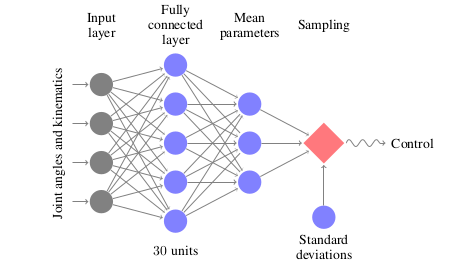

Here is the corresponding code.

In [ ]:
class TunableVarianceContinuousActor(ContinuousAgent):
    def __init__(self, state_dim, hidden_layers, action_dim):
        super().__init__()
        layers = [state_dim] + list(hidden_layers) + [action_dim]
        self.model = build_mlp(layers, activation=nn.ReLU())

        # The standard deviation associated with each dimension
        self.std_param = nn.parameter.Parameter(torch.randn(action_dim, 1))

        # We use the softplus function to compute the variance for the normal
        # The base version computes \exp(1+log(x)) component-wise
        # https://pytorch.org/docs/stable/generated/torch.nn.Softplus.html
        self.soft_plus = torch.nn.Softplus()

    def get_distribution(self, obs: torch.Tensor):
        mean = self.model(obs)
        return Independent(Normal(mean, self.soft_plus(self.std_param)), 1)

### State Dependent Variance Continuous Actors

Finally, the third and most complex possibility is to predict both the mean
*and* the variance.

In *State Dependent Variance Continuous Actors*, The standard deviation of the
Gaussian controlling stochasticity is defined as a function of the state,
exactly as the mean of the Gaussian. This is the most often used
representation.

As the mean and covariance matrix might share some common sources of
information, the implementation below supposes that there is a *backbone*
network, i.e. a function from the state space to a latent space. From this
latent space, both the mean and the diagonal of the variance can be predicted
(using a linear transformation, or whatever you fancy).

This type of policy is represented below.

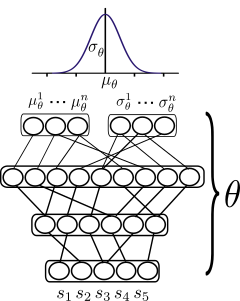

The problem with these types of policies is that neural networks are generally
initialized so that their output is close to 0. Having a standard deviation
close to 0 results in very few exploration, so the RL algorithm may not find
any reward, hence may not learn anything. Hence the algorithm may either use
an entropy loss function to tune the standard deviation to a reasonable value
(as in A2C and SAC), or use an additional exploration mechanism on top of the
policy stochasticity.

Here is the skeleton corresponding code: you will have to complete the
relevant parts (**exercise**)

In [ ]:
class StateDependentVarianceContinuousActor(ContinuousAgent):
    def __init__(self, state_dim, hidden_layers, action_dim):
        super().__init__()

        # Buils the "backbone" neural network
        backbone_dim = [state_dim] + list(hidden_layers)
        self.layers = build_mlp(backbone_dim, activation=nn.ReLU())
        self.backbone = nn.Sequential(*self.layers)

        # Add the functions to compute the mean and the diagonal of the variance (before the softplus)

        assert False, 'Not implemented yet'


    def get_distribution(self, obs: torch.Tensor) -> Distribution:
        # Compute the predicted action

        assert False, 'Not implemented yet'


### CriticAgent

To implement the critic, in A2C we use the value function $V(s)$. We thus call
upon the `VAgent` class. The VAgent below is a one hidden layer neural network
which takes an observation as input and whose output is the value of this
observation. It would be straightforward to define another CriticAgent (call
it a CriticQAgent by contrast to a CriticVAgent) that would take an
observation and an action as input.

In [ ]:
class VAgent(Agent):
    def __init__(self, state_dim, hidden_layers):
        super().__init__()
        self.is_q_function = False
        self.model = build_mlp(
            [state_dim] + list(hidden_layers) + [1], activation=nn.ReLU()
        )

    def forward(self, t, **kwargs):
        observation = self.get(("env/env_obs", t))
        critic = self.model(observation).squeeze(-1)
        self.set(("v_value", t), critic)

### Building the complete training and evaluation agents

In the piece of code below, we can see that we need the observation size and
the action size to build neural networks which implement the agents.

We also see that we build a different type of agent depending on whether the
environment takes discrete or continuous actions.

Finally, we see how the same ActionAgent is bound to the training environment
and the evaluation environment.

Apart from that, the code below is rather straightforward.

Note that we have not defined anything about data collection, using a
RolloutBuffer or something to store the n_step return so far. This will come
inside the training loop below.

Interestingly, the loop between the policy and the environment is first
defined as a collection of agents, and then embedded into a single
TemporalAgent.

The main loop below is very similar to the one of the [basic version of
A2C](http://master-dac.isir.upmc.fr/rld/rl/06-1-a2c_basic.student.ipynb)
where some elements are explained.

A new thing in this version is that we clip the gradient on the actor's
weights with the following line:

`torch.nn.utils.clip_grad_norm_(tr_agent.parameters(),
cfg.algorithm.max_grad_norm)`

This is useful because the probability of some actions can be close to null,
then its log is close to minus infinity, and the gradient may explode.
Clipping the gradient prevents this from happening.

Note also that in the basic version the entropy was computed inside the main
loop from the log probability of the actions, whereas here the entropy is
written in the workspace by the agent.

In [ ]:
# Create the A2C Agent


class A2C(EpisodicAlgo):
    def __init__(self, cfg):
        super().__init__(cfg, autoreset=True)
        observation_size, n_actions = self.train_env.get_obs_and_actions_sizes()

        if self.train_env.is_continuous_action():
            self.train_policy = globals()[cfg.algorithm.action_agent](
                observation_size,
                cfg.algorithm.architecture.actor_hidden_size,
                n_actions,
            )
        else:
            self.train_policy = DiscreteActor(
                observation_size,
                cfg.algorithm.architecture.actor_hidden_size,
                n_actions,
            )

        self.t_critic_agent = TemporalAgent(
            VAgent(observation_size, cfg.algorithm.architecture.critic_hidden_size)
        )

        # Define the train and evaluation agents
        self.eval_policy = DeterministicAgent(self.train_policy)

    def run(self):
        cfg = self.cfg

        # Configure the optimizer over the a2c agent
        optimizer = setup_optimizer(cfg.optimizer, self.train_policy, self.t_critic_agent)
        all_agents = Agents(self.train_policy, self.t_critic_agent)

        # Training loop
        for train_workspace in iter_partial_episodes(self, cfg.algorithm.n_steps):
            # Compute the critic value over the whole workspace
            self.t_critic_agent(train_workspace, n_steps=cfg.algorithm.n_steps)

            transition_workspace = train_workspace.get_transitions()

            v_value, terminated, reward, action, action_logp = transition_workspace[
                "v_value",
                "env/terminated",
                "env/reward",
                "action",
                "action_logprobs",
            ]

            # Determines whether values of the critic should be propagated
            # True if the episode reached a time limit or if the task was not done
            # See https://github.com/osigaud/bbrl/blob/master/docs/time_limits.md
            must_bootstrap = ~terminated

            # To be completed...

            assert False, 'Not implemented yet'


            # Evaluate if needed
            self.evaluate()

### Compute critic loss

This time we use the Generalized Advantage Estimate (GAE) from [John
Schulmann's paper](https://arxiv.org/pdf/1506.02438.pdf), with a $\lambda$
factor helping to find a better bias-variance compromize. Again, this is not
what is done in the original A2C paper, as the GAE paper was published later.
But what A2C does corresponds to using the GAE with $\lambda=1$.

In [ ]:
from bbrl.utils.functional import gae


def compute_critic_loss(cfg, reward, must_bootstrap, v_value):
    # Compute temporal difference
    reward = reward[1]
    next_val = v_value[1]
    current_val = v_value[0]
    mb = must_bootstrap[1]
    target = gae(
        reward,
        next_val,
        mb,
        current_val,
        cfg.algorithm.discount_factor,
        cfg.algorithm.gae,
    )
    td = target - current_val
    td_error = td**2
    critic_loss = td_error.mean()
    return critic_loss, td

### Compute Actor Loss

We compute the log probability of actions times the temporal difference error.

In [ ]:
def compute_actor_loss(action_logp: torch.Tensor, td: torch.Tensor):
    """Compute the actor loss

    :param action_logp: The log p(action | state)
    :param td: Temporal differences
    """
    actor_loss = action_logp[:-1] * td.detach()
    return actor_loss.mean()


# Show tensorboard
setup_tensorboard("./outputs/tblogs")

## Definition of the parameters

The logger is defined as `bbrl.utils.logger.TFLogger` so as to use a tensorboard visualisation.

In [ ]:
params = {
    "save_best": True,
    "plot_policy": True,
    "base_dir": "${gym_env.env_name}/a2c-${algorithm.action_agent}-S${algorithm.seed}_${current_time:}",
    "algorithm": {
        "seed": 4,
        "gae": 0.8,
        "discount_factor": 0.95,
        "entropy_coef": 0.001,
        "critic_coef": 1.0,
        "actor_coef": 0.1,
        # Training
        "n_envs": 8,
        "n_steps": 16,
        "max_epochs": 2_000,
        "max_grad_norm": 0.5,
        # Evaluation
        "nb_evals": 10,
        "eval_interval": 1000,
        # You can change the chosen action agent here
        "action_agent": "ConstantVarianceContinuousActor",
        # "action_agent": "StateDependentVarianceContinuousActor",
        # "action_agent": "TunableVarianceContinuousActor",
        "architecture": {
            "actor_hidden_size": [25, 25],
            "critic_hidden_size": [24, 36],
        },
    },
    "gym_env": {
        "env_name": "CartPoleContinuous-v1",
    },
    "optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 0.01,
    },
}

In [ ]:
a2c = A2C(OmegaConf.create(params))
a2c.run()
a2c.visualize_best()